In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision
import os
import zipfile

from pathlib import Path

import requests
import numpy as np

from torch import nn
from torchvision import transforms
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

torch version: 2.3.1+cu121
torchvision version: 0.18.1+cu121


In [2]:
print(torch.__version__)
print(torch.version.cuda)

2.3.1+cu121
12.1


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Input and Output Paths

In [69]:
# path to training dataset
denoised_oct_training_dataset = r"D:\VIP Cup\output_datasets\denoised_training_dataset"
model_save_path = r"D:\VIP Cup\oct_classification\saved_models\trained_resnet-18_models"

Function for open a .tiff file

In [6]:
from PIL import Image

def convert_tiff_to_rgb_np_array(image_path):
  image = Image.open(image_path)
  if image.mode == 'RGBA':
    # Convert RGBA to RGB by discarding the alpha channel
    image = image.convert('RGB')
  return np.array(image)

Sample denoised image

(300, 300, 3)

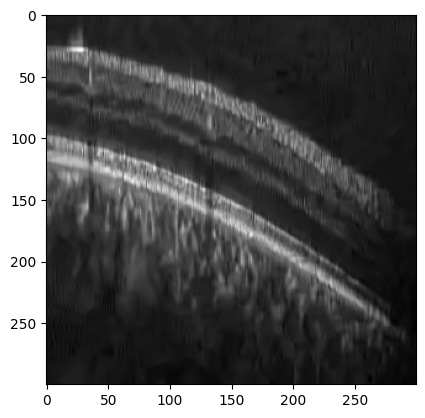

In [12]:
test_path = r"D:/VIP Cup/output_datasets/denoised_training_dataset/0/RawDataQA (8)/RawDataQA8 (17)_denoised_.tiff"
test_sample_denoised_img = convert_tiff_to_rgb_np_array(test_path)
plt.imshow(test_sample_denoised_img)
test_sample_denoised_img.shape

In [13]:
os.listdir(os.path.join(denoised_oct_training_dataset, "0"))

['RawDataQA (1)',
 'RawDataQA (10)',
 'RawDataQA (11)',
 'RawDataQA (12)',
 'RawDataQA (13)',
 'RawDataQA (14)',
 'RawDataQA (15)',
 'RawDataQA (16)',
 'RawDataQA (17)',
 'RawDataQA (18)',
 'RawDataQA (19)',
 'RawDataQA (2)',
 'RawDataQA (20)',
 'RawDataQA (21)',
 'RawDataQA (22)',
 'RawDataQA (23)',
 'RawDataQA (24)',
 'RawDataQA (25)',
 'RawDataQA (26)',
 'RawDataQA (27)',
 'RawDataQA (28)',
 'RawDataQA (29)',
 'RawDataQA (3)',
 'RawDataQA (30)',
 'RawDataQA (31)',
 'RawDataQA (32)',
 'RawDataQA (33)',
 'RawDataQA (34)',
 'RawDataQA (35)',
 'RawDataQA (36)',
 'RawDataQA (37)',
 'RawDataQA (38)',
 'RawDataQA (39)',
 'RawDataQA (4)',
 'RawDataQA (40)',
 'RawDataQA (41)',
 'RawDataQA (42)',
 'RawDataQA (5)',
 'RawDataQA (6)',
 'RawDataQA (7)',
 'RawDataQA (8)',
 'RawDataQA (9)']

Spliting training and validation datasets from the given denoised icip training dataset

In [15]:
import random
from sklearn.model_selection import train_test_split

def split_train_test_data(dataset, test_ratio: float):
    """
    Split the dataset into training and testing datasets.

    Parameters:
    - dataset: The dataset to be split.
    - test_ratio: The ratio of the testing dataset size to the total dataset size.

    Returns:
    - train_dataset: The training dataset as paths.
    - test_dataset: The testing dataset as paths.
    """

    random.seed(42)
    train_dataset, test_dataset = [],[]

    labels = os.listdir(dataset)
    for label in labels:
        label_path = os.path.join(dataset, label)
        cases = os.listdir(label_path)
        train_cases, test_cases = train_test_split(cases, test_size=test_ratio, random_state=42)
        train_case_count = len(train_cases)
        test_case_count = len(test_cases)

        for train_case in train_cases:
            train_dataset.append(os.path.join(label_path, train_case))
        for test_case in test_cases:
            test_dataset.append(os.path.join(label_path, test_case))

        print(f"class {label} has {train_case_count} training cases and {test_case_count} testing cases.")
        

    return train_dataset, test_dataset, labels

In [16]:
train_dataset_path, test_dataset_path, classes = split_train_test_data(denoised_oct_training_dataset, test_ratio=0.1667)
print()
print(f"Number of training samples: {len(train_dataset_path)}")
print(f"Number of testing samples: {len(test_dataset_path)}")

class 0 has 34 training cases and 8 testing cases.
class 1 has 24 training cases and 6 testing cases.
class 2 has 23 training cases and 5 testing cases.

Number of training samples: 81
Number of testing samples: 19


In [17]:
train_dataset_path[:5]

['D:\\VIP Cup\\output_datasets\\denoised_training_dataset\\0\\RawDataQA (37)',
 'D:\\VIP Cup\\output_datasets\\denoised_training_dataset\\0\\RawDataQA (15)',
 'D:\\VIP Cup\\output_datasets\\denoised_training_dataset\\0\\RawDataQA (34)',
 'D:\\VIP Cup\\output_datasets\\denoised_training_dataset\\0\\RawDataQA (20)',
 'D:\\VIP Cup\\output_datasets\\denoised_training_dataset\\0\\RawDataQA (25)']

In [18]:
test_dataset_path[:5]

['D:\\VIP Cup\\output_datasets\\denoised_training_dataset\\0\\RawDataQA (32)',
 'D:\\VIP Cup\\output_datasets\\denoised_training_dataset\\0\\RawDataQA (21)',
 'D:\\VIP Cup\\output_datasets\\denoised_training_dataset\\0\\RawDataQA (17)',
 'D:\\VIP Cup\\output_datasets\\denoised_training_dataset\\0\\RawDataQA (33)',
 'D:\\VIP Cup\\output_datasets\\denoised_training_dataset\\0\\RawDataQA (13)']

Creating the volumetric dataset

In [19]:
def create_vol_datasets(dataset):
    """load pickle files as a numpy array associated with their labels and return them as a dataset"""
    
    dataset_list = []
    for path in dataset:
        vol_oct_image = []
        oct_images = os.listdir(path)

        #sorting 2d layers
        case_no = lambda x: int(x.split('(')[-1].split(')')[0])
        sorted_oct_image_paths = sorted(oct_images, key = lambda y: case_no(y))

        for oct_image in sorted_oct_image_paths:
            oct = convert_tiff_to_rgb_np_array(os.path.join(path, oct_image))
            vol_oct_image.append(oct)

        #sort vol_oct_image by the name of the file
        #vol_oct_image.sort(key=lambda x: int(x.split("RawDataQA")[1].split(" ")[1].split(")")[0]))

        vol_oct = np.array(vol_oct_image)

        label = os.path.basename(os.path.dirname(path))
        dataset_list.append((vol_oct, label))
        
    return dataset_list

In [20]:
train_vol_dataset = create_vol_datasets(train_dataset_path)
test_vol_dataset = create_vol_datasets(test_dataset_path)

Validating the process

In [21]:
len(train_vol_dataset), len(test_vol_dataset)

(81, 19)

In [22]:
train_vol_dataset[80][0][129,:,:,:].shape

(300, 300, 3)

Creating 2D sclices of dataset from subjective data

In [24]:
def create_2D_dataset(vol_dataset):
    """create a 2D dataset from the 3D dataset"""
    
    dataset_2D = []
    for vol_oct, label in vol_dataset:
        depth = vol_oct.shape[0]
        for i in range(depth):
            oct_image = vol_oct[i,:,:,:]
            #transposed oct_image to match the input shape of the model
            #oct_image = np.transpose(oct_image, (2, 0, 1))
            dataset_2D.append((oct_image, label))
    return dataset_2D

In [25]:
train_dataset = create_2D_dataset(train_vol_dataset)
test_dataset = create_2D_dataset(test_vol_dataset)


In [26]:
training_cases = len(train_dataset)
testing_cases = len(test_dataset)
total_cases = training_cases + testing_cases
test_ratio = testing_cases / total_cases

print(f"Number of training samples: {training_cases}")
print(f"Number of testing samples: {testing_cases}")
print(f"Number of total samples: {total_cases}")
print(f"Ratio of the testing dataset size to the total dataset size: {test_ratio:.4f}")
print(f"Sample shape of the training data: {train_dataset[0][0].shape}")

Number of training samples: 14698
Number of testing samples: 3340
Number of total samples: 18038
Ratio of the testing dataset size to the total dataset size: 0.1852
Sample shape of the training data: (300, 300, 3)


Class Names

In [27]:
classes

['0', '1', '2']

In [28]:
class_names = {classes[0]: "Normal", classes[1]: "Diabetes", classes[2]: "non-Diabetes"}
class_names

{'0': 'Normal', '1': 'Diabetes', '2': 'non-Diabetes'}

We are intending to use ResNet-18 for the classification task. We will use the pre-trained model.

Creating the transforms

In [29]:
#Get a set of pretrained model weights

# Get the weights
weights = torchvision.models.ResNet18_Weights.DEFAULT  
weights 

ResNet18_Weights.IMAGENET1K_V1

In [30]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Create manual transforms to include the RGB conversion also

In [32]:
from PIL import Image
import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode

crop_size = 300
resize_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
interpolation = InterpolationMode.BILINEAR

final_transform = transforms.Compose([
    #transforms.CenterCrop(crop_size),
    transforms.Resize(resize_size, interpolation=interpolation),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

Validation of the process by looking t=at the samples

tensor([[[-1.7069, -1.5357, -1.3987,  ..., -1.5014, -1.6213, -1.4843],
         [-1.7069, -1.5357, -1.3987,  ..., -1.4843, -1.6213, -1.4672],
         [-1.6898, -1.5185, -1.3815,  ..., -1.4672, -1.5870, -1.4500],
         ...,
         [-0.7993, -0.9192, -0.8335,  ..., -0.6109, -0.6623, -0.6452],
         [-0.7650, -0.8849, -0.8164,  ..., -0.5938, -0.6452, -0.6281],
         [-0.7479, -0.8507, -0.7822,  ..., -0.5767, -0.6109, -0.6281]],

        [[-1.6155, -1.4405, -1.3004,  ..., -1.4055, -1.5280, -1.3880],
         [-1.6155, -1.4405, -1.3004,  ..., -1.3880, -1.5280, -1.3704],
         [-1.5980, -1.4230, -1.2829,  ..., -1.3704, -1.4930, -1.3529],
         ...,
         [-0.6877, -0.8102, -0.7227,  ..., -0.4951, -0.5476, -0.5301],
         [-0.6527, -0.7752, -0.7052,  ..., -0.4776, -0.5301, -0.5126],
         [-0.6352, -0.7402, -0.6702,  ..., -0.4601, -0.4951, -0.5126]],

        [[-1.3861, -1.2119, -1.0724,  ..., -1.1770, -1.2990, -1.1596],
         [-1.3861, -1.2119, -1.0724,  ..., -1

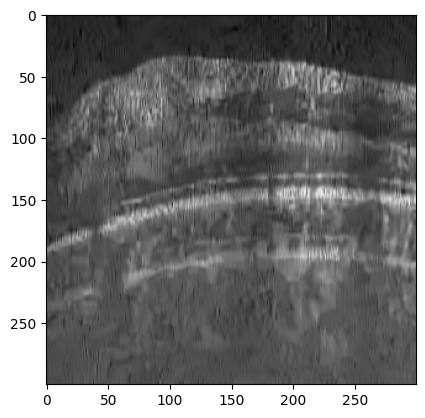

In [34]:
from PIL import Image

#`sample` is a numpy array representing a grayscale image
sample = train_dataset[0][0]
sample = Image.fromarray(sample)
plt.imshow(sample, cmap='gray')

# Apply the final transformation
transformed_sample = final_transform(sample)
transformed_sample


In [35]:
transformed_sample.shape

torch.Size([3, 224, 224])

In [36]:
train_dataset[0]

(array([[[23, 23, 23],
         [27, 27, 27],
         [40, 40, 40],
         ...,
         [25, 25, 25],
         [34, 34, 34],
         [38, 38, 38]],
 
        [[23, 23, 23],
         [27, 27, 27],
         [40, 40, 40],
         ...,
         [23, 23, 23],
         [35, 35, 35],
         [38, 38, 38]],
 
        [[23, 23, 23],
         [27, 27, 27],
         [40, 40, 40],
         ...,
         [23, 23, 23],
         [36, 36, 36],
         [39, 39, 39]],
 
        ...,
 
        [[83, 83, 83],
         [68, 68, 68],
         [73, 73, 73],
         ...,
         [85, 85, 85],
         [86, 86, 86],
         [87, 87, 87]],
 
        [[85, 85, 85],
         [69, 69, 69],
         [76, 76, 76],
         ...,
         [87, 87, 87],
         [87, 87, 87],
         [87, 87, 87]],
 
        [[85, 85, 85],
         [70, 70, 70],
         [77, 77, 77],
         ...,
         [88, 88, 88],
         [88, 88, 88],
         [86, 86, 86]]], dtype=uint8),
 '0')

In [37]:
train_dataset[13000][0].shape, train_dataset[13000][1]

((300, 300, 3), '2')

Creating datasetss and applying transforms

In [38]:
def one_hot_encode(label, num_classes):
    '''One hot encode a label with a specific number of classes'''
    torch_label = torch.tensor(int(label))
    return torch.nn.functional.one_hot(torch_label, num_classes).float()


In [39]:
def create_preprocessed_datasets(dataset, dataset_name:str):
    """create datasets using the CustomDataset class"""

    data, targets = [], []
    num_classes = len(classes)

    for i in range(len(dataset)):
        data_array = dataset[i][0]
        to_be_transposed_image = Image.fromarray(data_array)
        transformed_data = final_transform(to_be_transposed_image)
        data.append(transformed_data)

        target = dataset[i][1]
        label = one_hot_encode(label=target, num_classes=num_classes)
        targets.append(label)

    print(f"Number of {dataset_name} samples: {len(data)}")
    print(f"Number of {dataset_name} targets: {len(targets)}")
    print(f"Number of {dataset_name} datapoints in input list: {len(dataset)}")
    print(f"Sample of {dataset_name} data: {data[0]}")
    print(f"Sample of {dataset_name} data shape:{data[0].shape}")
    print(f"Sample of {dataset_name} target: {targets[0]}")
    print(f"Sample of {dataset_name} target shape: {targets[0].shape}")

    return data, targets

Creating train and test datasets

In [40]:
train_data, train_targets = create_preprocessed_datasets(train_dataset, "training dataset")
test_data, test_targets = create_preprocessed_datasets(test_dataset, "testing dataset")

Number of training dataset samples: 14698
Number of training dataset targets: 14698
Number of training dataset datapoints in input list: 14698
Sample of training dataset data: tensor([[[-1.7069, -1.5357, -1.3987,  ..., -1.5014, -1.6213, -1.4843],
         [-1.7069, -1.5357, -1.3987,  ..., -1.4843, -1.6213, -1.4672],
         [-1.6898, -1.5185, -1.3815,  ..., -1.4672, -1.5870, -1.4500],
         ...,
         [-0.7993, -0.9192, -0.8335,  ..., -0.6109, -0.6623, -0.6452],
         [-0.7650, -0.8849, -0.8164,  ..., -0.5938, -0.6452, -0.6281],
         [-0.7479, -0.8507, -0.7822,  ..., -0.5767, -0.6109, -0.6281]],

        [[-1.6155, -1.4405, -1.3004,  ..., -1.4055, -1.5280, -1.3880],
         [-1.6155, -1.4405, -1.3004,  ..., -1.3880, -1.5280, -1.3704],
         [-1.5980, -1.4230, -1.2829,  ..., -1.3704, -1.4930, -1.3529],
         ...,
         [-0.6877, -0.8102, -0.7227,  ..., -0.4951, -0.5476, -0.5301],
         [-0.6527, -0.7752, -0.7052,  ..., -0.4776, -0.5301, -0.5126],
         [-0.

Creating custom tensor datasets

In [88]:
from torch.utils.data import TensorDataset

def create_dataset(data_tensor, target_tensor):
    dataset = TensorDataset(data_tensor, target_tensor)
    return dataset

In [89]:
# Step 1: Convert lists to tensors
train_data_tensor = torch.stack(train_data)
print(f"train_data_tensor shape: {train_data_tensor.shape}")

train_targets_tensor = torch.stack(train_targets)
print(f"train_targets_tensor shape: {train_targets_tensor.shape}")

test_data_tensor = torch.stack(test_data)
print(f"test_data_tensor shape: {test_data_tensor.shape}")

test_targets_tensor = torch.stack(test_targets)
print(f"test_targets_tensor shape: {test_targets_tensor.shape}")

train_data_tensor shape: torch.Size([14698, 3, 224, 224])
train_targets_tensor shape: torch.Size([14698, 3])
test_data_tensor shape: torch.Size([3340, 3, 224, 224])
test_targets_tensor shape: torch.Size([3340, 3])


In [90]:
train_dataset =  create_dataset(train_data_tensor, train_targets_tensor)
test_dataset = create_dataset(test_data_tensor, test_targets_tensor)

In [93]:
train_dataset, test_dataset

(<torch.utils.data.dataset.TensorDataset at 0x22b55ca48d0>,
 <torch.utils.data.dataset.TensorDataset at 0x22b55cbbf90>)

Creating DataLoaders

In [193]:
import os
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dataset,
    test_dataset, 
    batch_size,
    num_workers=0
):
    # Create DataLoaders
    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle= True,
        num_workers = num_workers,
        pin_memory = True
    )

    test_dataloader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle= False,
        num_workers = num_workers,
        pin_memory = True
    )

    return train_dataloader, test_dataloader

In [236]:
train_dataloader, test_dataloader = create_dataloaders(train_dataset=train_dataset, 
                                                      test_dataset=test_dataset, 
                                                      batch_size=32)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x22e278c12d0>,
 <torch.utils.data.dataloader.DataLoader at 0x22e279ee450>)

Iterating through dataloaders

In [237]:
for X_batch, y_batch in train_dataloader:
    print("Shape of the first element in X_batch:", X_batch.shape)
    print("Shape of the first element in y_batch:", y_batch.shape)
    break  # Just to print the first batch and stop

Shape of the first element in X_batch: torch.Size([32, 3, 224, 224])
Shape of the first element in y_batch: torch.Size([32, 3])


Getting pre-trained model

In [238]:
#ResNet-101 model
weights = torchvision.models.ResNet18_Weights.DEFAULT
model = torchvision.models.resnet18(weights=weights).to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [239]:
#Summary of  the ResNet-101
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [240]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

Freezing feature layers and creating new classifier layer

In [241]:
#freeze all layers
for param in model.parameters():
    param.requires_grad = False

#Replacing final fully connected layer
model.fc = torch.nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features=512, out_features=32),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=32, out_features=3),
    nn.Softmax()
)

#unfreeze final fully connected layer
for param in model.fc.parameters():
    param.requires_grad = True

Model Summary

In [242]:
#Summary of  the ResNet-101
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]) 

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

Accuracy function

In [243]:
import torchmetrics
import torchmetrics.classification

TASK = 'multiclass'
NUM_CLASSES = 3

device = "cuda" if torch.cuda.is_available() else "cpu"

def accuracy(y_true, y_pred):
    accuracy = torchmetrics.Accuracy(task = TASK, num_classes=NUM_CLASSES).to(device)
    return accuracy(y_pred, y_true)

def precision(y_true, y_pred):
    precision = torchmetrics.Precision(task = TASK, num_classes=NUM_CLASSES).to(device)
    return precision(y_pred, y_true)

def sensitivity(y_true, y_pred):
    sensitivity = torchmetrics.Recall(task = TASK, num_classes=NUM_CLASSES).to(device)
    return sensitivity(y_pred, y_true)

def specificity(y_true, y_pred):
    specificity = torchmetrics.Specificity(task = TASK, num_classes=NUM_CLASSES).to(device)
    return specificity(y_pred, y_true)

def f_score(y_true, y_pred):
    f_scaore = torchmetrics.F1Score(task = TASK, num_classes=NUM_CLASSES).to(device)
    return f_score(y_pred, y_true)

Loss function

In [244]:
#define accuracy, loss
loss_fn = nn.CrossEntropyLoss()

Train Model

In [245]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimize_with_regularize: bool,
               learning_rate: float,
               device: torch.device):
    
    """Train a PyTorch model for one epoch"""

    #training
    model.train()

    train_loss, train_accuracy = 0, 0

    #initializing the optimizer
    if optimize_with_regularize:
        #optimizing with regularization
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.0001)  #Apply L2 regularization here        
    else:
        #optimizing without regularization
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    #iterate over batches
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), (y_batch).to(device)

        #forward pass
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #calculate training loss
        train_loss += loss.item()

        #calculate training accuracy
        train_accuracy += accuracy(y_batch.to(torch.int), y_pred)

    train_loss /= len(dataloader)
    train_accuracy /= len(dataloader)

    return train_loss, train_accuracy

In [246]:
def test_step(model:torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    
    """Test a PyTorch model for one epoch"""

    #evaluation
    model.eval()

    test_loss, test_accuracy = 0, 0

    #disable gradient computation
    with torch.inference_mode():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            #forward pass
            test_preds = model(X_batch)

            loss = loss_fn(test_preds, y_batch)
            test_loss += loss.item()

            #calculate test accuracy
            test_accuracy += accuracy(y_batch.to(torch.int), test_preds)
            
        
        test_loss /= len(dataloader)
        test_accuracy /= len(dataloader)

    return test_loss, test_accuracy

Training only the fully connected layer

In [247]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_fc(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimize_with_regularize: bool,
          learning_rate: float,          
          device: torch.device,
          epochs: int):
    
    """Train a PyTorch model"""

    #Create empty results dictionary
    results = {
        "train_loss": [],
        "train_accuracy": [],
        "test_loss": [],
        "test_accuracy": []
    }

    #loop throug trainning and testing epochs
    for epoch in tqdm(range(epochs)):
        #train step
        train_loss, train_accuracy = train_step(model,train_dataloader,loss_fn,optimize_with_regularize,
                                                learning_rate, device=device)
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)

        #test step
        test_loss, test_accuracy = test_step(model, test_dataloader, loss_fn, device)
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_accuracy)

        print(f"Epoch: {epoch+1}/{epochs}, train_loss: {train_loss:.4f}, train_accuracy: {train_accuracy:.4f}, test_loss: {test_loss:.4f}, test_accuracy: {test_accuracy:.4f}")

        #save the model for epoch 0, 5, 10, 15, 20
        if (epoch+1)%5 == 0:
            model_cpu = model.to("cpu")
            model_out_path = f"{model_save_path}/resnet-18_fc_only_epoch_{epoch+1}.pth"
            torch.save(model_cpu.state_dict(), model_out_path)
            model.to(device)

    return results
    

Evaluating the model

In [248]:
import torch
import matplotlib.pyplot as plt

def plot_loss_curves(results):
    """
    Plots the loss curves of the training and test datasets.
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    accuracy = torch.tensor(results["train_accuracy"]).cpu()  # Convert to tensor and move to CPU
    test_accuracy = torch.tensor(results["test_accuracy"]).cpu()  # Convert to tensor and move to CPU
    
    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

training final fully connected layers for 20 epochs with a learning rate of 5e-4

In [249]:
#Set the random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

#setup training and save the results
train_results = train_fc(model= model,
                train_dataloader= train_dataloader,
                test_dataloader= test_dataloader,
                loss_fn= loss_fn,
                optimize_with_regularize=True,
                learning_rate=1e-4,
                device= device,
                epochs= 20)

# End the timer
end_time = timer()
execution_time = end_time - start_time
print(f"Execution time: {execution_time}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1/20, train_loss: 1.0206, train_accuracy: 0.6869, test_loss: 0.9544, test_accuracy: 0.7413
Epoch: 2/20, train_loss: 0.9430, train_accuracy: 0.7494, test_loss: 0.8938, test_accuracy: 0.7930
Epoch: 3/20, train_loss: 0.9083, train_accuracy: 0.7710, test_loss: 0.8825, test_accuracy: 0.7853
Epoch: 4/20, train_loss: 0.8910, train_accuracy: 0.7775, test_loss: 0.8730, test_accuracy: 0.7875
Epoch: 5/20, train_loss: 0.8795, train_accuracy: 0.7815, test_loss: 0.8525, test_accuracy: 0.8083
Epoch: 6/20, train_loss: 0.8728, train_accuracy: 0.7862, test_loss: 0.8476, test_accuracy: 0.8091
Epoch: 7/20, train_loss: 0.8663, train_accuracy: 0.7904, test_loss: 0.8432, test_accuracy: 0.8082
Epoch: 8/20, train_loss: 0.8693, train_accuracy: 0.7871, test_loss: 0.8485, test_accuracy: 0.8023
Epoch: 9/20, train_loss: 0.8613, train_accuracy: 0.7921, test_loss: 0.8315, test_accuracy: 0.8160
Epoch: 10/20, train_loss: 0.8554, train_accuracy: 0.7951, test_loss: 0.8324, test_accuracy: 0.8151
Epoch: 11/20, train

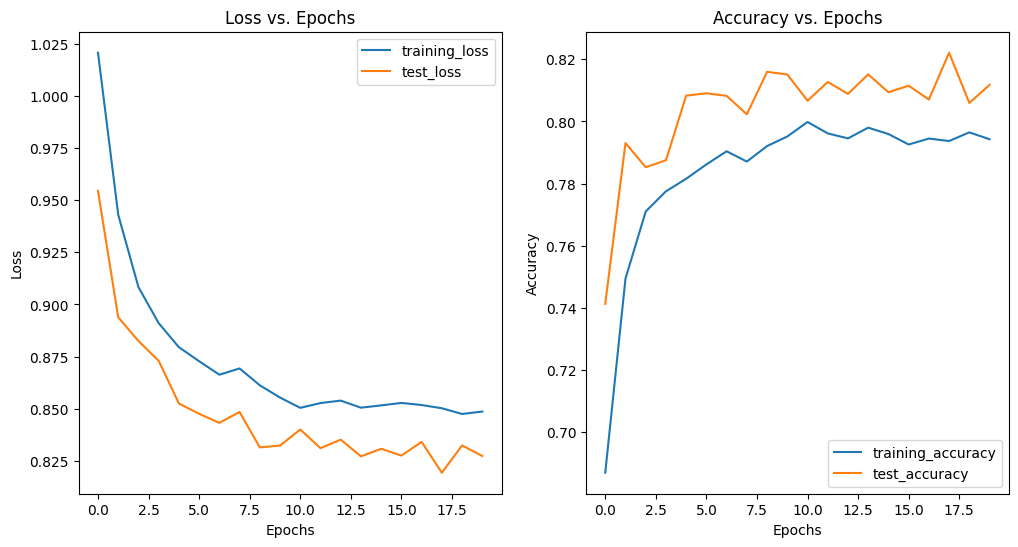

In [250]:
plot_loss_curves(train_results)

Now, we are going to unfreeze last Residual network block which is layer 4 and train the model with a low 1e-6 learning rate

In [251]:
#unfreeze final fully connected layer
for param in model.fc.parameters():
    param.requires_grad = True

#unfreeze the last 2 layers
for param in model.layer4.parameters():
    param.requires_grad = True

In [252]:
#Summary of  the ResNet-101
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]) 

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

In [253]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_layer4_and_fc(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimize_with_regularize: bool,
          learning_rate: float,          
          device: torch.device,
          epochs: int):
    
    """Train a PyTorch model"""

    #Create empty results dictionary
    results = {
        "train_loss": [],
        "train_accuracy": [],
        "test_loss": [],
        "test_accuracy": []
    }

    #loop throug trainning and testing epochs
    for epoch in tqdm(range(epochs)):
        #train step
        train_loss, train_accuracy = train_step(model,train_dataloader,loss_fn,optimize_with_regularize,
                                                learning_rate, device=device)
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)

        #test step
        test_loss, test_accuracy = test_step(model, test_dataloader, loss_fn, device)
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_accuracy)

        print(f"Epoch: {epoch+1}/{epochs}, train_loss: {train_loss:.4f}, train_accuracy: {train_accuracy:.4f}, test_loss: {test_loss:.4f}, test_accuracy: {test_accuracy:.4f}")

        #save the model for epoch 0, 5, 10, 15, 20
        model_cpu = model.to("cpu")
        model_out_path = f"{model_save_path}/resnet-18_layer_4_and_fc_epoch_{epoch+1}.pth"
        torch.save(model_cpu.state_dict(), model_out_path)
        model.to(device)

    return results
    

In [254]:
#Set the random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

#results = {"train_loss": [], "train_accuracy": [], "test_loss": [], "test_accuracy": []}

#setup training and save the results
train_results_2 = train_layer4_and_fc(model= model,
                train_dataloader= train_dataloader,
                test_dataloader= test_dataloader,
                loss_fn= loss_fn,
                optimize_with_regularize=True,
                learning_rate=2e-6,
                device= device,
                epochs= 5)

# End the timer
end_time = timer()
execution_time = end_time - start_time
print(f"Execution time: {execution_time}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/5, train_loss: 0.8186, train_accuracy: 0.8181, test_loss: 0.8036, test_accuracy: 0.8261
Epoch: 2/5, train_loss: 0.7718, train_accuracy: 0.8509, test_loss: 0.7847, test_accuracy: 0.8419
Epoch: 3/5, train_loss: 0.7387, train_accuracy: 0.8745, test_loss: 0.7781, test_accuracy: 0.8456
Epoch: 4/5, train_loss: 0.7165, train_accuracy: 0.8905, test_loss: 0.7739, test_accuracy: 0.8473
Epoch: 5/5, train_loss: 0.6943, train_accuracy: 0.9051, test_loss: 0.7636, test_accuracy: 0.8539
Execution time: 242.83550320001086


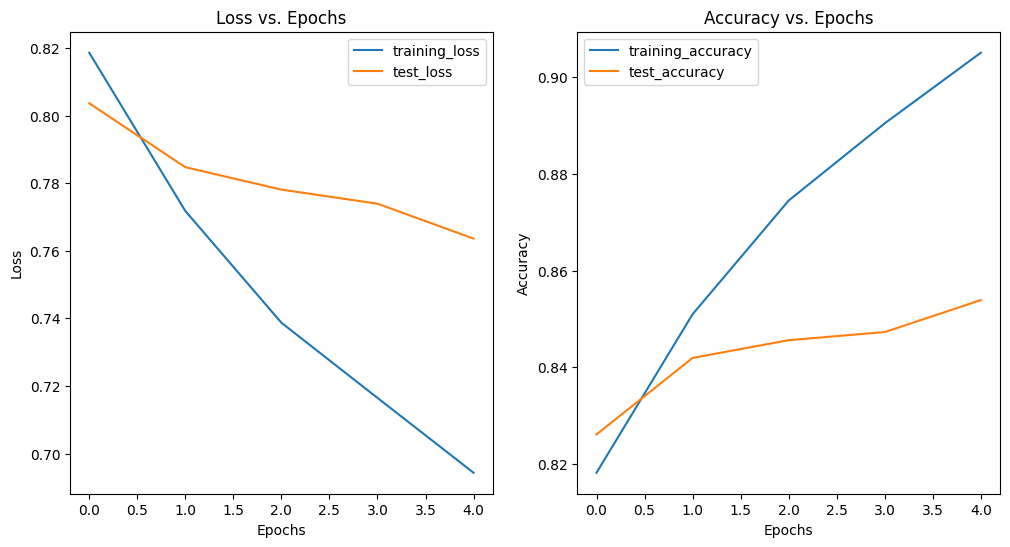

In [255]:
plot_loss_curves(train_results_2)

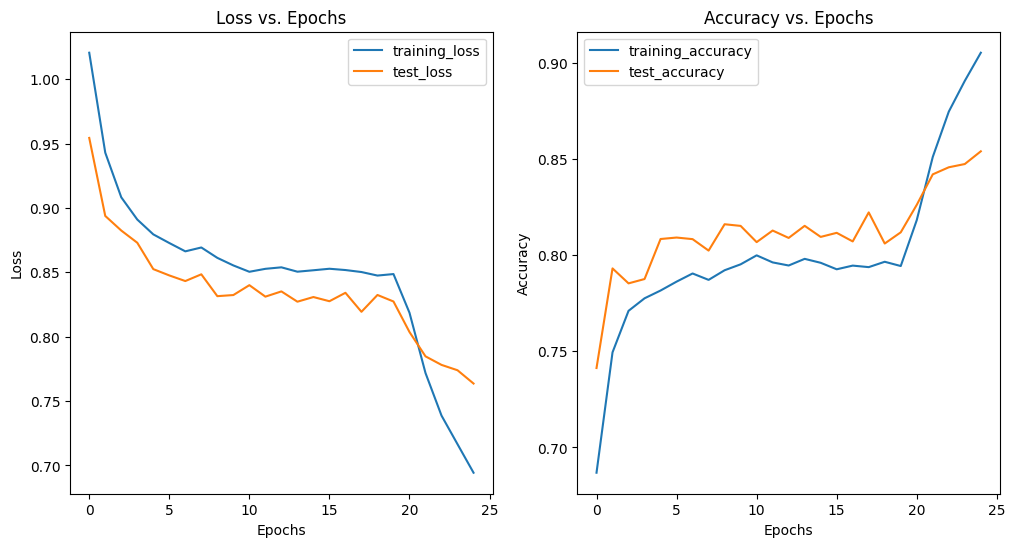

In [256]:
combined_results = {key: train_results[key] + train_results_2[key] for key in train_results}
plot_loss_curves(combined_results)

Saving the bast model

In [301]:
final_CNN_model = "D:/VIP Cup/final_oct_model.pt"

model_cpu = model.to("cpu")
model_out_path = final_CNN_model
torch.save(model_cpu.state_dict(), model_out_path)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

load the best model

In [136]:
# Step 1: Initialize the model architecture
model = torchvision.models.resnet18()

#Replacing final fully connected layer
model.fc = torch.nn.Sequential(
    nn.Dropout(p=0.32),
    nn.Linear(in_features=512, out_features=32),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=32, out_features=3),
    nn.Softmax()
)

# Step 2: Load the saved state dictionary
load_to_model_path = r"D:\VIP Cup\oct_classification\saved_models\trained_resnet-18_models\resnet-18_layer_4_and_fc_epoch_5.pth"
model.load_state_dict(torch.load(load_to_model_path))

# Step 3: Move the model to GPU if needed
model = model.to(device)

Predicticting the sucject classes for the test dataset of ICIP training dataset

Predict the case

In [257]:
def predict_single_oct(model, image, device):
    """
    Predict the class of a single image.
    """
    # Add a batch dimension
    image = image.unsqueeze(0)
    # Make predictions
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        preds = model(image)
    # Get the predicted class
        prob = torch.max(preds).item()
        pred_class = classes[torch.argmax(preds, axis=1).item()]
    return pred_class, prob

In [269]:
def predict_vol_image(vol_image_path: str,
                         model: torch.nn.Module,
                         device: torch.device,
                         cutoff_prob: float):
    """
    Load an images from a .pkl file path and convert it to a tensor.
    """
    tiff_files = os.listdir(vol_image_path)
    case_class = os.path.basename(os.path.dirname(vol_image_path))
    predicted_classes_of_2d_octs = []
    depth = len(tiff_files)

    for tiif_file in tiff_files:
        oct_2d = convert_tiff_to_rgb_np_array(os.path.join(vol_image_path, tiif_file))
        to_be_transformed = Image.fromarray(oct_2d)
        transformed = final_transform(to_be_transformed)
        
        predicted_class, predicted_prob = predict_single_oct(model, transformed, device)
        if predicted_prob>= cutoff_prob:
            predicted_classes_of_2d_octs.append(predicted_class)
        
        #print(f"Predicted class: {predicted_class}")


    predicted_case_class = max(set(predicted_classes_of_2d_octs), key = predicted_classes_of_2d_octs.count)
    predicted_correctly = (case_class==predicted_case_class)

    if predicted_correctly:
        print(f"Volumetric OCT at {vol_image_path} predicted correctly.")
    else:
        print(f"Volumetric OCT at {vol_image_path} predicted incorrectly.")
    #print(f"Predicted class for volumetric OCT at {vol_image_path}: {predicted_case_class}")

    return case_class, predicted_case_class
    #return predicted_case_class
        
        

In [270]:
def accuracy_eval_results(y_true: list, y_predict: list):
    """calculates accuracy"""
    y_true_array = np.array(y_true)
    y_predict_array = np.array(y_predict)

    if len(y_true_array) == len(y_predict_array):
        n = len(y_true_array)
    else:
        raise Exception("lengths of the 2 input arrays are different!")
    
    correct_predictions = np.sum((y_true_array==y_predict_array)*1)
    accuracy_eval = correct_predictions/n

    return accuracy_eval

Evaluating the results on validating dataset (test dataset in training icip training dataset)

In [271]:
def eval_test_dataset(test_vol_dataset_list: list,
                         model: torch.nn.Module,
                         device: torch.device,
                         cutoff_prob: float):
    
    case_classes = []
    predicted_case_classes = []
    
    """Predict the results for the all teesst dataset"""
    for case in test_vol_dataset_list:
        class_true, class_predict = predict_vol_image(vol_image_path=case, model=model, device=device, cutoff_prob=cutoff_prob)
        case_classes.append(class_true)
        predicted_case_classes.append(class_predict)

    eval_results = {
        "true classes": case_classes,
        "predicted classes": predicted_case_classes
    }

    accuracy_eval = accuracy_eval_results(y_true=case_classes, y_predict=predicted_case_classes)
    print(f"Accuracy of the predictions for volumetric test cases: {accuracy_eval}")

    return eval_results, accuracy_eval
    

Training dataset accuracy

In [272]:
eval_results, accuracy_eval = eval_test_dataset(test_vol_dataset_list= test_dataset_path,
                                                         model=model,
                                                         device=device,
                                                         cutoff_prob=0.6)

Volumetric OCT at D:\VIP Cup\output_datasets\denoised_training_dataset\0\RawDataQA (32) predicted correctly.
Volumetric OCT at D:\VIP Cup\output_datasets\denoised_training_dataset\0\RawDataQA (21) predicted correctly.
Volumetric OCT at D:\VIP Cup\output_datasets\denoised_training_dataset\0\RawDataQA (17) predicted correctly.
Volumetric OCT at D:\VIP Cup\output_datasets\denoised_training_dataset\0\RawDataQA (33) predicted correctly.
Volumetric OCT at D:\VIP Cup\output_datasets\denoised_training_dataset\0\RawDataQA (13) predicted correctly.
Volumetric OCT at D:\VIP Cup\output_datasets\denoised_training_dataset\0\RawDataQA (7) predicted correctly.
Volumetric OCT at D:\VIP Cup\output_datasets\denoised_training_dataset\0\RawDataQA (27) predicted correctly.
Volumetric OCT at D:\VIP Cup\output_datasets\denoised_training_dataset\0\RawDataQA (36) predicted correctly.
Volumetric OCT at D:\VIP Cup\output_datasets\denoised_training_dataset\1\RawDataQA-1 (7) predicted correctly.
Volumetric OCT at D

In [273]:
print(eval_results["true classes"])
print(eval_results["predicted classes"])

['0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2']
['0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '1']
